In [16]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib nbagg

# Definitions and Data

In [17]:
f_sample = (1/25E-9); # Hz
freq_HPF = 1/(4762*8E-9); # rad/sec
freq_HPFd = freq_HPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
delta = np.concatenate((np.zeros((1,100)),np.ones((1,1)),np.zeros((1,100))),axis=1)

In [18]:
# Filter Definitions
b, a = signal.butter(1, freq_HPF, 'high', analog=True)

# Analog Filter Response

<IPython.core.display.Javascript object>


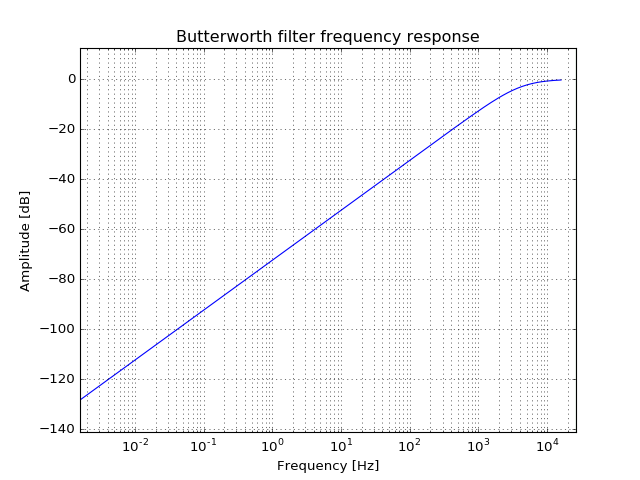

In [19]:
w, h = signal.freqs(b, a)
plt.figure(1)
plt.semilogx(w/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(freq_HPF, color='green') # cutoff frequency
plt.show()

# Equivalent Digital Filter Response

<IPython.core.display.Javascript object>


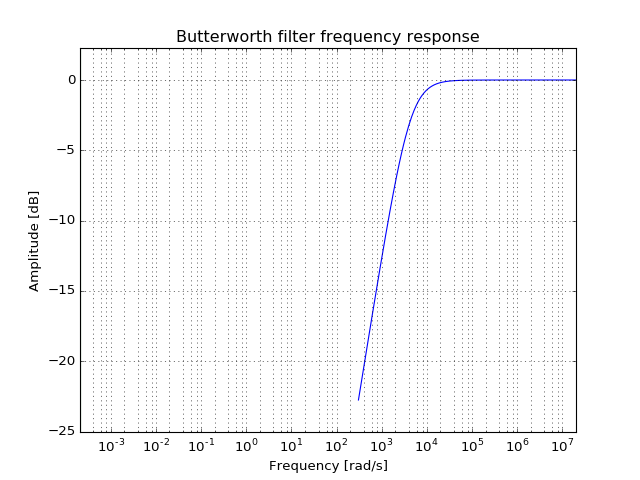

/home/viherbos/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


In [20]:
b, a = signal.butter(1, freq_HPFd, 'high', analog=False)
# Filter Response
w, h = signal.freqz(b, a, worN=2**16)                # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
plt.figure(2)
plt.semilogx(w*(f_sample)/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(freq_HPFd, color='green') # cutoff frequency
plt.show()

# Filtering Operation

In [21]:
signal_in = np.concatenate((np.zeros((1,1000)),np.ones((1,4000)),np.zeros((1,20000))),axis=1)
signal_out = signal.lfilter(b,a,signal_in[0,0:])

<IPython.core.display.Javascript object>


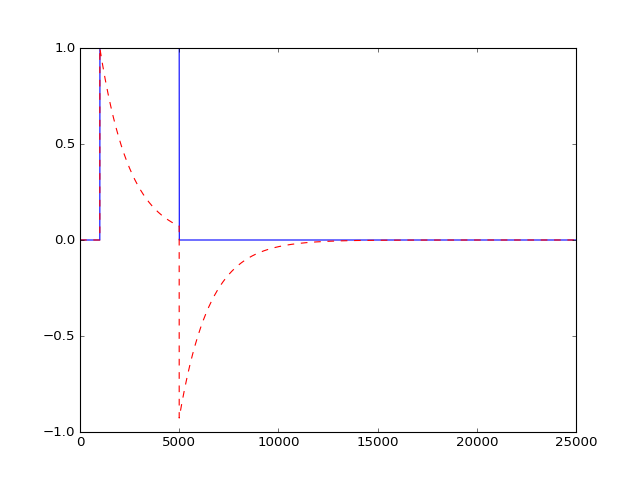

25000


In [22]:
plt.figure(3)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
print np.size(signal_out)
plt.plot(range(0,np.size(signal_in),1),signal_out,'r--', linewidth=1)
plt.show()

#  Complex Filter Composition - 
# CAPACITOR DF EFFECT on ENERGY estimation 

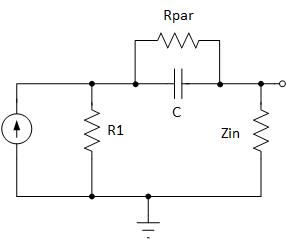

In [23]:
Image(filename = "scheme.png")

$$\frac{v_O}{i_I}=\frac{Z_{in}R_1}{(R_1+Z_{in})+R_{par}}\frac{1+R_{par}Cs}{1+\frac{(R_1+Z_{in}).R_{par}}{R_{par}+(R_1+Z_{in})}.Cs} 
= \frac{Z_{in}R_1}{(R_1+Z_{in})+R_{par}}\frac{1+R_{par}Cs}{1+(R_1+Z_{in})//R_{par}.Cs} 
$$
$$ \frac{v_O}{i_I}=\frac{Z_{in}R_1}{(R_1+Z_{in})+R_{par}}.\frac{1}{1+(R_1+Z_{in})//R_{par}.Cs}+R_1//Z_{in}.\frac{(R_1+Z_{in})//R_{par}.Cs}{1+(R_1+Z_{in})//R_{par}.Cs} $$

In [24]:
rpar=10E6; 
C=8E-9; 
R1=1567; 
Zin=62; 
r_i=R1+Zin; 
R=r_i*rpar/(r_i+rpar); 

MEASURED_GAIN = 582.237
A=MEASURED_GAIN/(R1*Zin/(R1+Zin))
GAIN=(R1*Zin/(R1+Zin))*A 

freq_HPF=1/(R*C);
freq_LPFz=1/(R*C);
freq_LPF1=3E6*2*np.pi;
freq_LPF2=10E6*2*np.pi;
zero_rpar=1/(rpar*C)

In [25]:
freq_HPFd=freq_HPF / (f_sample*np.pi) ; print 'HPF(rad/sec) =',freq_HPF,'// (half-cycles/sample) =',freq_HPFd
freq_LPF1d=freq_LPF1 / (f_sample*np.pi) ; print 'LPF1(rad/sec) =',freq_LPF1,'// (half-cycles/sample) =',freq_LPF1d 
freq_LPF2d=freq_LPF2 / (f_sample*np.pi) ; print 'LPF2(rad/sec) =',freq_LPF2,'// (half-cycles/sample) =',freq_LPF2d
freq_zerod= zero_rpar / (f_sample*np.pi) ; print 'Zero_Rpar(rad/sec) =',zero_rpar,'// (half-cycles/sample) =',freq_zerod

HPF(rad/sec) = 76746.6927563 // (half-cycles/sample) = 0.000610730775906
LPF1(rad/sec) = 18849555.9215 // (half-cycles/sample) = 0.15
LPF2(rad/sec) = 62831853.0718 // (half-cycles/sample) = 0.5
Zero_Rpar(rad/sec) = 12.5 // (half-cycles/sample) = 9.94718394324e-08


In [26]:
GAIN_b=A
b0, a0 = signal.butter(1, freq_HPFd, 'high', analog=False); 
b0z, a0z = signal.butter(1, freq_HPFd, 'low', analog=False);
b_aux = b0z*(R1*Zin)/(R1+Zin+rpar)+b0*(R1*Zin/(R1+Zin));
a_aux = a0;

b1l, a1l = signal.butter(1, freq_LPF1d, 'low', analog=False); 
b2l, a2l = signal.butter(4, freq_LPF2d, 'low', analog=False);
b_auxl = np.convolve(b1l,b2l); a_auxl = np.convolve(a1l,a2l);

b = GAIN_b*np.convolve(b_auxl,b_aux); a = np.convolve(a_auxl,a_aux);

<IPython.core.display.Javascript object>


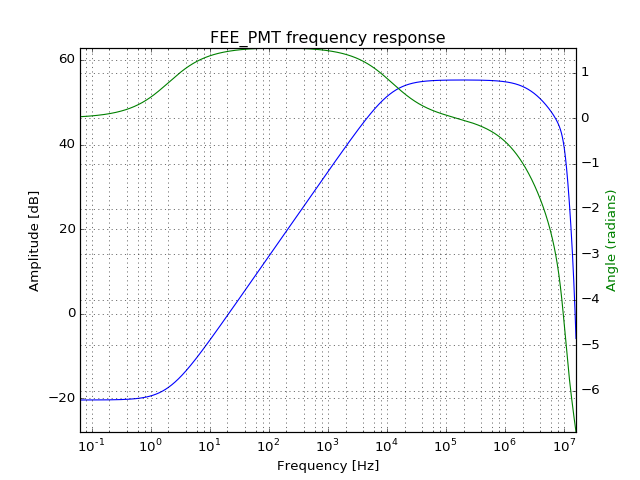

In [27]:
w, h = signal.freqz(b, a, worN=np.logspace(-8,0.4,40000))                # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
fig = plt.figure(4)
ax1 = fig.add_subplot(111)
plt.semilogx(w*(f_sample)/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('FEE_PMT frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.semilogx(w*(f_sample)/(2*np.pi), angles,'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')

plt.show()

# Filter is defined by Polynomials b & a. Use lfilter for filter computation

<IPython.core.display.Javascript object>


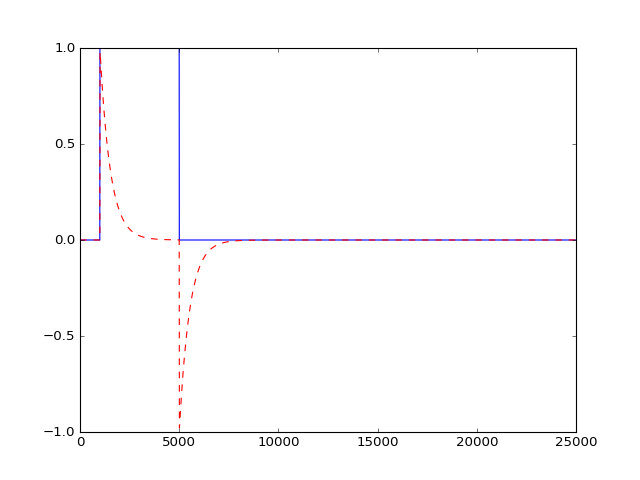

25000


In [28]:
signal_out = signal.lfilter(b,a,signal_in[0,0:])


plt.figure(5)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
print np.size(signal_out)
plt.plot(range(0,np.size(signal_in),1),signal_out/GAIN,'r--', linewidth=1)
plt.show()

# Recontruction Using BLRc (BLR for Calibration)

<IPython.core.display.Javascript object>


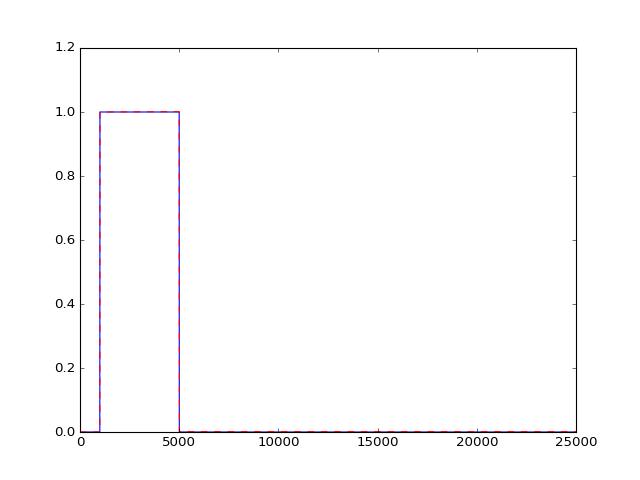

Input Energy = 4000.0
Reconstructed Energy = 3999.13257118
Error in Energy Computation (%) =  0.0216857204521


In [29]:
recons=BLRc(signal_daq=signal_out,coef=freq_HPFd*np.pi,thr1 = 0.01)/GAIN

plt.figure(6)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
plt.plot(range(0,np.size(recons),1),recons,'r--', linewidth=1)
plt.show()
# plt.figure(6)
# plt.plot(range(0,np.size(recons),1),recons-signal_in[0,0:],'g--', linewidth=0.5)
# plt.show()
energy_mea=np.sum(recons[1000:5000])
print 'Input Energy =', np.sum(signal_in)
print 'Reconstructed Energy =', energy_mea
print 'Error in Energy Computation (%) = ', (np.sum(signal_in)-energy_mea)/np.sum(signal_in)*100